In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    print("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    print("✓ Manual login completed")

2026-01-16 10:35:16 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ Logged in with HF_TOKEN from environment


In [4]:
import sys
from pathlib import Path

# 프로젝트 경로 설정
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
sys.path.insert(0, str(project_root))

import torch
import gc
from PIL import Image
from typing import Optional

from diffusers import DiffusionPipeline
from config import TORCH_DTYPE
from services.monitor import flush_gpu
from helper_dev_utils import get_auto_logger

logger = get_auto_logger()

class FluxGenerator:
    """
    diffusers/FLUX.1-dev-bnb-4bit (Pre-quantized) 모델 사용
    - L4 GPU (22GB)에서 약 12~14GB VRAM 점유
    - 다운로드 용량이 12GB 내외로 작아서 디스크 공간 부족 문제 해결
    """

    def __init__(self):
        # [핵심] 이미 4bit로 줄어든 공식 모델 ID 사용
        #self.model_id = "diffusers/FLUX.1-dev-bnb-4bit"
        self.model_id = "diffusers/FLUX.1-dev-bnb-8bit"
        
        self.pipe_txt2img = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"FluxGenerator initialized using: {self.model_id}")

    def _flush_gpu(self):
        flush_gpu()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def _load_txt2img_pipeline(self):
        if self.pipe_txt2img is not None:
            return self.pipe_txt2img

        logger.info(f"Loading Quantized Pipeline from {self.model_id}...")
        self._flush_gpu()
        
        # 파이프라인 로드
        self.pipe_txt2img = DiffusionPipeline.from_pretrained(
            self.model_id,
            torch_dtype=TORCH_DTYPE,
        )
        
        # [수정 전] 메모리 절약 모드 (속도 느림, GPU 쉼)
        # self.pipe_txt2img.enable_model_cpu_offload()
        
        # [수정 후] GPU 풀가동 모드 (속도 빠름, VRAM 약 12~14GB 사용 예상)
        # L4의 22GB VRAM을 믿고 모든 컴포넌트(텍스트 인코더 포함)를 GPU에 올립니다.
        self.pipe_txt2img.to("cuda")
        
        logger.info("Pipeline loaded to CUDA (Max Performance Mode)")
        return self.pipe_txt2img

    def generate_background_and_compose_image(
        self,
        prompt: str,
        input_image: Optional[Image.Image] = None,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        seed: int = None,
        **kwargs
    ) -> Image.Image:
        
        # 시드 설정
        generator = None
        if seed is not None:
            generator = torch.Generator(device="cpu").manual_seed(seed)
        
        logger.info(f"Generating image... Prompt: {prompt[:50]}")
        
        # 파이프라인 로드
        pipe = self._load_txt2img_pipeline() 
        self._flush_gpu()

        # 추론 실행
        with torch.no_grad():
            result = pipe(
                prompt=prompt,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
                max_sequence_length=512
            )
        
        image = result.images[0]
        self._flush_gpu()
        return image

flux_generator = FluxGenerator()


2026-01-16 10:35:17 I [ipykernel_launcher:34] - FluxGenerator initialized using: diffusers/FLUX.1-dev-bnb-8bit


2026-01-16 10:35:17 I [ipykernel_launcher:82] - Generating image... Prompt: High-quality product photography, input image plac
2026-01-16 10:35:17 I [ipykernel_launcher:46] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-8bit...


model_index.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

text_encoder_2/model-00001-of-00002.safe(…):   0%|          | 0.00/4.88G [00:00<?, ?B/s]

text_encoder_2/model-00002-of-00002.safe(…):   0%|          | 0.00/3.04G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer_2/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.98G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/1.94G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module 'T5EncoderModel' has been loaded in `bitsandbytes` 8bit and moving it to cuda via `.to()` is not supported. Module is still on cuda:0.
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cuda via `.to()` is not supported. Module is still on cuda:0.


2026-01-16 10:38:18 I [ipykernel_launcher:62] - Pipeline loaded to CUDA (Max Performance Mode)


/home/spai0433/miniconda3/envs/py311_adv2/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


  0%|          | 0/10 [00:00<?, ?it/s]

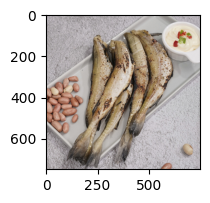

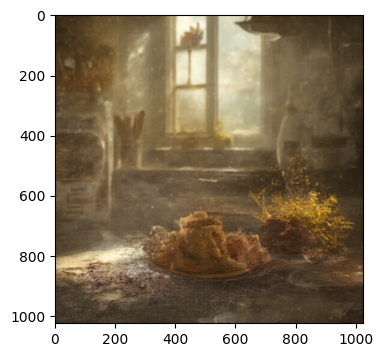

In [5]:
import matplotlib.pyplot as plt

# 테스트 1: 광고용 상품 이미지 생성 및 편집
ad_prompt = """High-quality product photography, input image placed on a rustic wooden table, soft sunlight coming from the side, bokeh background of a sunlit kitchen, realistic textures, deep shadows, ultra-detailed 8K resolution.
"""

image01 = Image.open("image01.png")
plt.figure(figsize=(2,2))
plt.imshow(image01)

ad_image = flux_generator.generate_background_and_compose_image(
    prompt=ad_prompt,
    input_image=image01,
    width=1024,
    height=1024,
    num_inference_steps=10,
    guidance_scale=1.0,
    seed=42
)

plt.figure(figsize=(4,4))
plt.imshow(ad_image)
